# Molecular dating and relaxed clock models

1. Estimation du temps de divergence entre deux espèces (en supposant que les deux évoluent à la même vitesse)
    
<center>$l = t \times r$</center>

- $l$: longueur de la branche
- $t$: temps de divergence
- $r$: vitesse d'évolution
    
On peut se focaliser sur:
- la phylogénie sur les séquences
- l'évolution moléculaire

Dans ce tp on va faire de la datation moléculaire à partir d'un arbre non-raciné en utilisant le __temps__ de __divergence__ $t$ et la __vitesse__ d'__évolution__ $r$, avec une phylogénie déjà fixée en utilisant un modèle non daté (cfr. TPs précedents).

## Modèle d'horloge moléculaire stricte

L'arbre `prim.tree` n'est pas ultra-métrique comme on peut l'observer en le visualisant avec `figtree`. La lignée qui contient _Macaca mulatta_ semblerait avoir une vitesse d'évolution supérieur aux autre lignées. <br/>
Les données sont contenues dans le fichier `prim4fold.nex` et il contient uniquement les troisièmes positions codantes dégénerées __4-fold__. Une position est dite __4-fold__ dégénerée si n'importe quel nucléotide à la troisième position spécifie le même acide aminé, on aurait parlé de __2-fold__ pour deux nucléotides à la troisième position pour le même acide aminé.

### Graphe du modèle
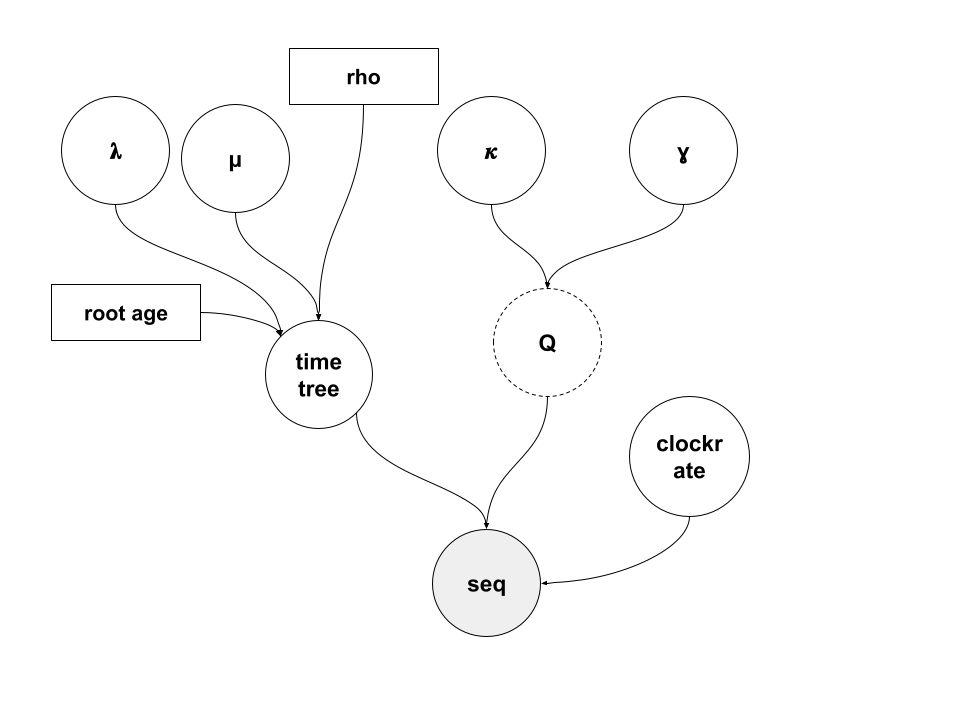

In [ ]:
# read nucleotide data
data <- readDiscreteCharacterData("../TP5/prim4fold.nex")

n_species <- data.ntaxa()
n_branches <- 2 * n_species - 2 # car on veut un arbre enraciné
taxa <- data.taxa()

# root age
root_age ~ dnUniform(0,100)

L'age de la racine sera fixe mais on la défini quand même dans une variable aléatoire. Puis on va supposer que l'arbre est produit à partir d'un processus de naissance-déces, avec des ratios non-connus et égales de spéciation $lambda$ et d'extinction $mu$. <br/>
On suppose aussi la fraction $rho$ de toutes les espèces existantes sont présentes dans notre jeu de données, et que ces espèces ont été échantillonnées aléatoirement parmi toutes les espèces existantes.

In [ ]:
# tree is produced by a birth death process

# speciation rate
lambda ~ dnExponential(1.0)

# extinction rate
mu ~ dnExponential(1.0)

# sampling fraction (in the present)
# here, we assume that all species (all primates in this case) have been sampled
rho <- 1.0

# time tree produced by a birth-death process (BDP)
timetree ~ dnBDP(lambda, mu, rho, root_age, samplingStrategy="uniform", condition="nTaxa", taxa=taxa)

`timetree` est la variable aléatoire qu'ici on cherche à estimer. <br/>
Le processus naissance-morte en autres mots décrit le processus de spéciation-extinction.
<br/><br/>
Ensuite, on veut fixer la topologie de l'arbre, et en particulière en utilisant l'arbre `prim.tree` (produit en utilisant le script donné dans le _TP2_):

In [ ]:
# read tree from file
tree <- readTrees("../TP5/prim.tree", treetype="clock")[1]
# ajust terminal branch lengths so as to make the tree ultrametric
tree.makeUltrametric()

# set the value of the tree topology
timetree.setValue(tree)

# rescale root age to 1.0
# (all ages will be relative to the root)
root_age.setValue(1.0)

In [4]:
# we assume a strict molecular clock, of unknown rate
clockrate ~ dnExponential(1.0)

# and a T92 process
kappa ~ dnExponential(0.1)
gamma ~ dnBeta(1.0, 1.0)
Q := fnT92(kappa=kappa, gc=gamma)

seq ~ dnPhyloCTMC( tree=timetree, Q=Q, branchRates=clockrate, type="DNA" )
# le taux d'évolution dans toutes les branches est égale au clockrate
seq.clamp( data )

my_model = model(timetree)

# moves
moves = VectorMoves()

moves.append(mvScale(lambda, weight=1.0))
moves.append(mvScale(mu, weight=1.0))

moves.append(mvSlide(gamma, weight=1.0, delta=0.1))
moves.append(mvScale(kappa, weight=1.0))
moves.append(mvScale(clockrate, weight=1.0, lambda=0.1))

moves.append(mvNodeTimeSlideUniform(timetree, weight=20)) # bouge un seul noeud
moves.append(mvSubtreeScale(timetree, weight=4)) # bouge de façon proportionnel tous les noeuds d'un sous-arbre

monitors[1] = mnModel(filename="../TP5/analyses/prim_clock.log", printgen=10, separator = TAB)
monitors[2] = mnFile(timetree ,filename="../TP5/analyses/prim_clock.trees", printgen=10, separator = TAB)
monitors[3] = mnScreen(printgen=100, clockrate, kappa, gamma)

# Make the analysis object
analysis = mcmc(my_model, monitors, moves)
# Run the MCMC
analysis.run(10000)

treetrace = readTreeTrace("../TP5/analyses/prim_clock.trees", treetype="clock", burnin=0.1)
map_tree = mccTree(treetrace, "../TP5/analyses/prim_clock.tree")


   Successfully read one character matrix from file '../TP5/prim4fold.nex'
   Attempting to read the contents of file "prim.tree"
   Successfully read file
   
   Running MCMC simulation
   This simulation runs 1 independent replicate.
   The simulator uses 7 different moves in a random move schedule with 29 moves per iteration
   

Iter        |      Posterior   |     Likelihood   |          Prior   |      clockrate   |          gamma   |          kappa   |    elapsed   |        ETA   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
0           |       -19795.9   |       -19649.2   |       -146.711   |      0.4195803   |      0.6637932   |       11.69898   |   00:00:00   |   --:--:--   |
100         |       -18040.3   |         -17977   |       -63.3651   |      0.4959486   |      0.4856958   |        4.33897   |   00:00:05   |   --:--:--   |
200         |       -17868.7   | 

9000        |       -17802.7   |       -17680.3   |       -122.389   |      0.1779812   |      0.4856242   |       4.115675   |   00:08:08   |   00:00:54   |
9100        |       -17797.2   |       -17677.2   |       -120.092   |      0.1766934   |      0.4566437   |       4.089131   |   00:08:14   |   00:00:48   |
9200        |       -17793.2   |       -17672.4   |       -120.723   |      0.1838815   |      0.4681111   |       4.437838   |   00:08:21   |   00:00:43   |
9300        |       -17807.3   |       -17684.1   |       -123.175   |      0.1629914   |      0.4805041   |       4.225787   |   00:08:27   |   00:00:38   |
9400        |       -17807.9   |       -17680.4   |       -127.475   |        0.15907   |      0.4778766   |        3.77433   |   00:08:32   |   00:00:32   |
9500        |       -17808.3   |       -17678.8   |       -129.456   |       0.162669   |      0.4903908   |       3.985609   |   00:08:40   |   00:00:27   |
9600        |       -17804.8   |       -17678.7   | 

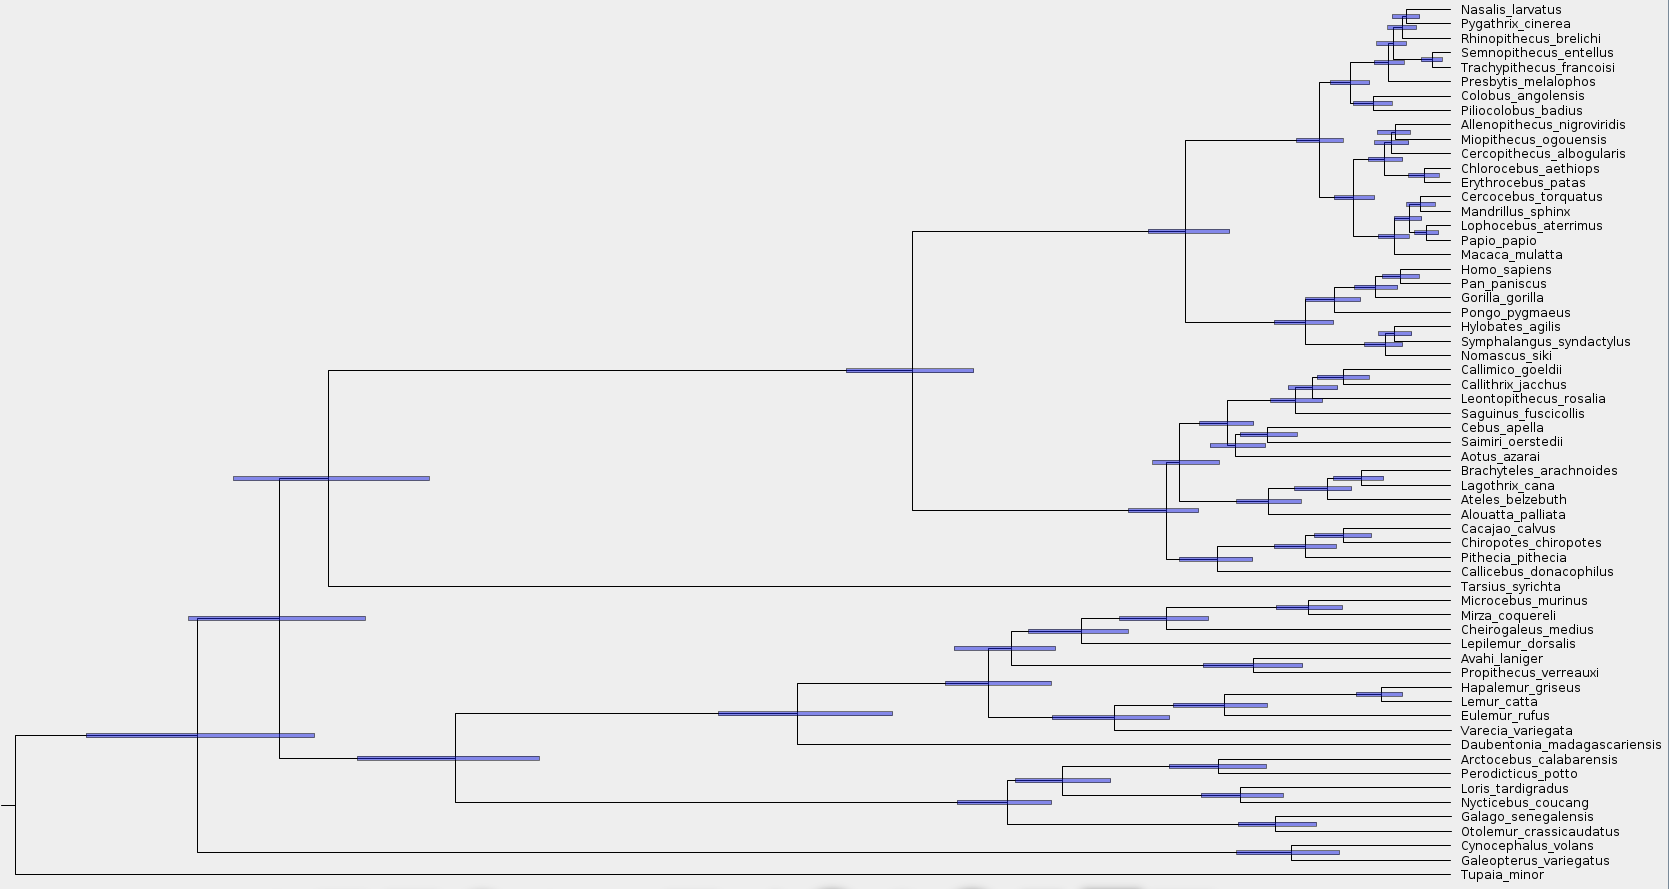

## Modèle d'horloge moléculaire relexée non auto-correlé

Le modèle précedent considère le ratio d'évolution comme fixe dans le temps. En pratique, cette hypothèse est généralement violée et ça peut être à l'origine d'erreurs dans l'estimation de la datation. Dans ce modèle on va donc autoriser des `clockrate` différents pour les différents branches.

`relvar` correspond à la variance rélative et elle définie comme: 
<center>$c = relvar = \frac{variance}{moyenne^2}$</center>

Sur la variable `clockrate` on pose donc un _a priori_ qui suit une loi _`Gamma`_ de parametre de __forme__ $\alpha$ et de __échelle__ $\beta$: 
<center>$m = moyenne = \frac{\alpha}{\beta}$ ; $variance = \frac{\alpha}{\beta^2}$
<br/><br/>
$c = \frac{variance}{moyenne^2} = \frac{\alpha \beta^2}{\alpha^2 \beta^2} = \frac{1}{\alpha} \rightarrow \alpha = \frac{1}{c}$
<br/>
$moyenne = \frac{\alpha}{\beta} \rightarrow \beta = \frac{\alpha}{moyenne}$</center>

On va donc mettre des _a priori_ sur la `moyenne` et la `variance rélative`.

### Graphe du modèle
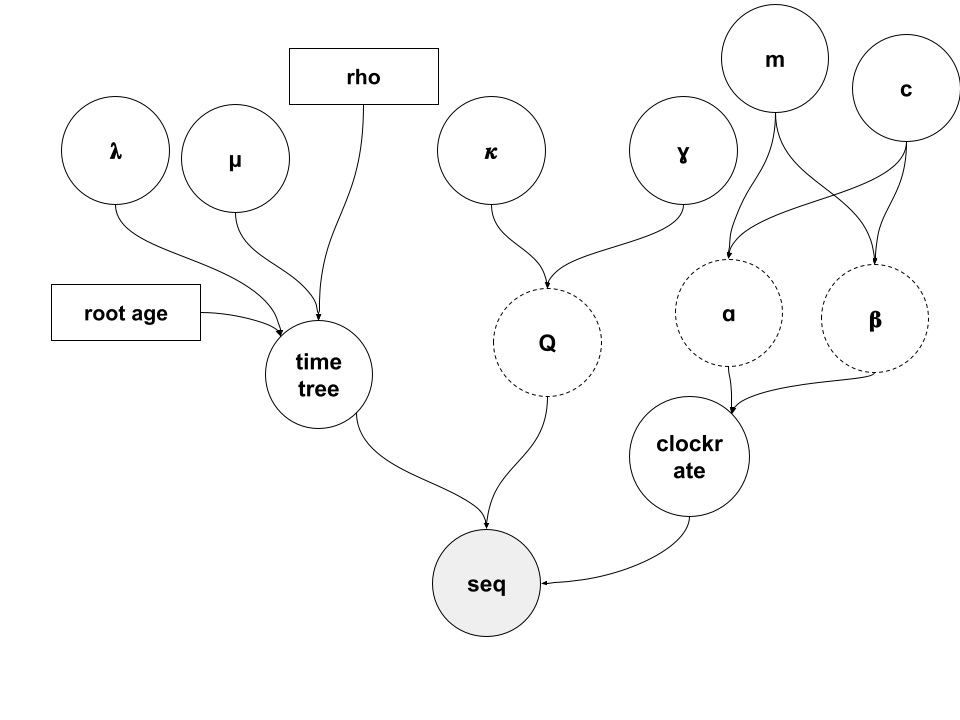

In [1]:
# read nucleotide data
data <- readDiscreteCharacterData("../TP5/prim4fold.nex")

n_species <- data.ntaxa()
n_branches <- 2 * n_species - 2
taxa <- data.taxa()

   Missing Variable:	Variable os does not exist

   Successfully read one character matrix from file '../TP5/prim4fold.nex'


In [2]:
# root age
root_age ~ dnUniform(0,100)
# tree is produced by a birth death process
# speciation rate
lambda ~ dnExponential(1.0)
# extinction rate
mu ~ dnExponential(1.0)
# sampling fraction (in the present)
# here, we assume that all species have been sampled
rho <- 1.0

In [3]:
# time tree produced by a birth-death process (BDP)
timetree ~ dnBDP(lambda, mu, rho, root_age, samplingStrategy="uniform", condition="nTaxa", taxa=taxa)

# read tree from file
tree <- readTrees("../TP5/prim.tree", treetype="clock")[1]
# ajust terminal branch lengths so as to make the tree ultrametric
tree.makeUltrametric()

# set the value of the tree topology
timetree.setValue(tree)

# rescale root age to 1.0
# (all ages will be relative to the root)
root_age.setValue(1.0)

# we assume a relaxed molecular clock, of unknown rate
mean_clockrate ~ dnExponential(1.0)
relvar_clockrate ~ dnExponential(1.0)

alpha := 1.0 / relvar_clockrate
beta := alpha / mean_clockrate

for (i in 1:n_branches) {
    clockrate[i] ~ dnGamma(alpha, beta)
}

# and a T92 process
kappa ~ dnExponential(0.1)
gamma ~ dnBeta(1.0, 1.0)
Q := fnT92(kappa=kappa, gc=gamma)

seq ~ dnPhyloCTMC( tree=timetree, Q=Q, branchRates=clockrate, type="DNA" )
seq.clamp( data )

my_model = model(timetree)

   Attempting to read the contents of file "prim.tree"
   Successfully read file


In [ ]:
# moves
moves = VectorMoves()

moves.append(mvScale(lambda, weight=1.0))
moves.append(mvScale(mu, weight=1.0))

moves.append(mvSlide(gamma, weight=1.0, delta=0.1))
moves.append(mvScale(kappa, weight=1.0))

for (i in 1:n_branches) {
    moves.append(mvScale(clockrate[i], weight=1.0, lambda=0.5))    
}
moves.append(mvScale(relvar_clockrate, weight=1.0, lambda=0.1))
moves.append(mvScale(mean_clockrate, weight=1.0, lambda=0.1))

moves.append(mvNodeTimeSlideUniform(timetree, weight=20))
moves.append(mvSubtreeScale(timetree, weight=4))

monitors[1] = mnModel(filename="../TP5/analyses/prim_clock_relax.log", printgen=10, separator = TAB)
monitors[2] = mnFile(timetree ,filename="../TP5/analyses/prim_clock_relax.trees", printgen=10, separator = TAB)
monitors[3] = mnScreen(printgen=100, mean_clockrate, relvar_clockrate, kappa, gamma)

# Make the analysis object
analysis = mcmc(my_model, monitors, moves)
# Run the MCMC
analysis.run(10000)

treetrace = readTreeTrace("../TP5/analyses/prim_clock_relax.trees", treetype="clock", burnin=0.1)
map_tree = mccTree(treetrace, "../TP5/analyses/prim_clock_relax.tree")

   
   Running MCMC simulation
   This simulation runs 1 independent replicate.
   The simulator uses 128 different moves in a random move schedule with 150 moves per iteration
   

Iter        |      Posterior   |     Likelihood   |          Prior   |          gamma   |          kappa   |   mean_clock..   |   relvar_clo..   |    elapsed   |        ETA   |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0           |       -29103.6   |       -28821.7   |       -281.848   |      0.7783623   |       5.991408   |       3.185572   |     0.08979722   |   00:00:00   |   --:--:--   |
100         |       -17797.2   |       -17613.7   |       -183.471   |      0.4891101   |       3.863935   |       2.034923   |      0.1646951   |   00:00:15   |   --:--:--   |
200         |       -17774.8   |       -17596.7   |       -178.085   |      0.4794109   |       3.931061   |  

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
4000        |         -17718   |       -17598.8   |        -119.23   |      0.4734604   |       3.979716   |       1.120602   |      0.2561093   |   00:09:53   |   00:14:49   |
4100        |       -17745.6   |         -17596   |       -149.581   |      0.4839212   |       4.079465   |       1.177187   |      0.3609954   |   00:10:08   |   00:14:34   |
4200        |         -17740   |       -17598.7   |       -141.344   |      0.5094566   |       3.898534   |       1.251001   |      0.3307264   |   00:10:22   |   00:14:18   |

## Calibration fossile